<a href="https://colab.research.google.com/github/MuhammedIrshath49/ICT3113_G10/blob/main/PTO_Group_10_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent CFO — Performance Optimization & Design

---
This is the starter notebook for your project. Follow the required structure below.


You will design and optimize an Agent CFO assistant for a listed company. The assistant should answer finance/operations questions using RAG (Retrieval-Augmented Generation) + agentic reasoning, with response time (latency) as the primary metric.

Your system must:
*   Ingest the company’s public filings.
*   Retrieve relevant passages efficiently.
*   Compute ratios/trends via tool calls (calculator, table parsing).
*   Produce answers with valid citations to the correct page/table.


## 1. Config & Secrets

Fill in your API keys in secrets. **Do not hardcode keys** in cells.

In [ ]:
import os
COMPANY_NAME = "DBS Bank"
DATA_DIR = "/content/drive/MyDrive/ICT3113 Group 10/Data" # Define data directory here




### API Keys and Secrets Management

This project utilizes the Google Gemini API. To use it, you will need a Gemini API key.

**How to obtain a Gemini API Key:**
1.  Go to Google AI Studio ([https://aistudio.google.com/](https://aistudio.google.com/)).
2.  Create or select a project.
3.  Generate an API key.

**How to store your API Key securely in Colab Secrets:**
1.  In the left sidebar of your Colab notebook, click on the "🔑 Secrets" tab.
2.  Click on "Add new secret".
3.  For the **Name**, enter `GOOGLE_API_KEY`. This is the name the code will use to access the key.
4.  For the **Value**, paste your Gemini API key.
5.  Make sure the "Notebook access" toggle is turned ON for this secret.

You can then access the secret in your code using:

## 2. Data Download (Dropbox)

*   Annual Reports: last 3–5 years.
*   Quarterly Results Packs & MD&A (Management Discussion & Analysis).
*   Investor Presentations and Press Releases.
*   These files must be submitted later as a deliverable in the Dropbox data pack.
*   Upload them under `/content/data/`.

Scope limit: each team will ingest minimally 15 PDF files total.


## 3. System Requirements

**Retrieval & RAG**
*   Use a vector index (e.g., FAISS, LlamaIndex) + a keyword filter (BM25/ElasticSearch).
*   Citations must include: report name, year, page number, section/table.

**Agentic Reasoning**
*   Support at least 3 tool types: calculator, table extraction, multi-document compare.
*   Reasoning must follow a plan-then-act pattern (not a single unstructured call).

**Instrumentation**
*   Log timings for: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total.
*   Log: tokens used, cache hits, tools invoked.
*   Record p50/p95 latencies.

In [ ]:
#Import from Google Drive. Change File path according to your file structure
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q sentence-transformers faiss-cpu numpy pandas scikit-learn PyMuPDF rank-bm25 google-generativeai tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 66.6 MB/s eta 0:00:00


In [ ]:
# TODO: Implement ingestion pipeline
import os
import time
import pickle
import logging
import pandas as pd
import numpy as np
import json
import re
from typing import List, Dict, Any, Tuple
from pathlib import Path

# RAG related libararies
import faiss
from sentence_transformers import SentenceTransformer
import fitz  # PyMuPDF for PDF processing
from rank_bm25 import BM25Okapi
import google.generativeai as genai # Gemini API for higher token limits

# Initialise logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# Tool for financial calculations
class CalculatorTool:
    def calculate_ratio(self, numerator: float, denominator: float, ratio_name: str = "") -> Dict[str, Any]:
        try:
            if denominator == 0:
                return {"error": f"Cannot calculate {ratio_name}: denominator is zero"}

            ratio = (numerator / denominator) * 100 if "ratio" in ratio_name.lower() else (numerator / denominator)
            return {
                "ratio_name": ratio_name,
                "numerator": numerator,
                "denominator": denominator,
                "result": round(ratio, 2),
                "formula": f"{numerator} / {denominator}"
            }
        except Exception as e:
            return {"error": str(e)}

    def trend_analysis(self, values: List[float], periods: List[str]) -> Dict[str, Any]:
        if len(values) != len(periods):
            return {"error": "Values and periods must have the same length"}

        if len(values) < 2:
            return {"error": "Need at least two data points for trend analysis"}

        # Calculate period-over-period changes
        changes = []
        for i in range(1, len(values)):
            if values[i-1] != 0:
                pct_change = ((values[i] - values[i-1]) / values[i-1]) * 100
                changes.append(round(pct_change, 2))
            else:
                changes.append(0)

        return {
            "periods": periods,
            "values": values,
            "period_changes": changes,
            "overall_trend": "increasing" if values[-1] > values[0] else "decreasing",
            "average_change": round(sum(changes) / len(changes), 2) if changes else 0
        }


# Tool for extracting table from dataset
class TableExtractionTool:
    def extract_financial_numbers(self, text: str) -> List[Dict[str, Any]]:
        # Pattern for numbers with currency/percentage
        patterns = [
            r'(\$|S\$|USD|SGD)?\s*(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s*(million|billion|thousand|m|bn|k)?',
            r'(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s*(%|percent|basis points|bps)',
            r'(NIM|CTI|ROE|ROA|CET1)\s*[:=]?\s*(\d+(?:\.\d+)?)\s*(%|bps)?'
        ]

        extracted = []
        for pattern in patterns:
            matches = re.finditer(pattern, text, re.IGNORECASE)
            for match in matches:
                extracted.append({
                    "text": match.group(0),
                    "value": match.group(2) if len(match.groups()) > 1 else match.group(1),
                    "context": text[max(0, match.start()-50):match.end()+50]  # 50 chars before and after
                })

        return extracted

    def parse_table_structure(self, text: str) -> Dict[str, Any]:
        lines = text.split('\n')
        table_lines = []

        for line in lines:
            # Look for lines that might be table rows (have multiple numbers/columns)
            if re.search(r'\d.*\d', line) and ('|' in line or '\t' in line or len(re.findall(r'\d+', line)) > 1):
                table_lines.append(line.strip())

        return {
            "potential_table_rows": table_lines[:10], # Return first 10 rows
            "row_count": len(table_lines)
        }


# Tool for comparing info across docs
class DocumentComparisonTool:
    def compare_metrics_across_docs(self, documents: List[Dict], metric_name: str) -> Dict[str, Any]:
        comparisons = []
        for doc in documents:
            # Extract metric from document text
            numbers = re.findall(r'\d+(?:\.\d+)?', doc.get('text', ''))
            filename = doc.get('metadata', {}).get('filename', 'unknown')

            comparisons.append({
                "document": filename,
                "metric_candidates": numbers[:5], # Return first 5 found numbers
                "text_snippet": doc.get('text', '')[:200] # First 200 chars
            })

        return {
            "metric_name": metric_name,
            "comparisons": comparisons
        }

# RAG functions
class CFORAGPipeline:
    def __init__(self, persist_dir="./cfo_rag_data"):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.persist_dir = persist_dir
        self.documents = []
        self.document_metadata = []
        self.index = None
        self.bm25 = None

        # Initialise tools
        self.calculator_tool = CalculatorTool()
        self.table_extraction_tool = TableExtractionTool()
        self.doc_comparison_tool = DocumentComparisonTool()

        # Create directory for persistence
        os.makedirs(self.persist_dir, exist_ok=True)

        # Performance tracking
        self.metrics = {
            'T_ingest': 0,
            'T_retrieve': 0,
            'T_rerank': 0,
            'documents_ingested': 0,
            }

        logger.info("Initialized CFO RAG Pipeline")

    # method for RAG Pipeline evaluation testing
    def load_data(self):
      # load saved index and documents
        try:
          with open(os.path.join(self.persist_dir, 'documents.pkl'), 'rb') as f:
              self.documents = pickle.load(f)

          with open(os.path.join(self.persist_dir, 'metadata.pkl'), 'rb') as f:
              self.document_metadata = pickle.load(f)

          self.index = faiss.read_index(os.path.join(self.persist_dir, 'faiss_index.bin'))

          with open(os.path.join(self.persist_dir, 'bm25.pkl'), 'rb') as f:
              self.bm25 = pickle.load(f)

          logger.info(f"Loaded {len(self.documents)} documents from {self.persist_dir}")

        except Exception as e:
            logger.error(f"Error loading data: {e}")


    def extract_text_from_pdf(self, pdf_path: str) -> List[Dict[str, Any]]:
        # for document chunking
        chunks = []

        try:
            doc = fitz.open(pdf_path)
            filename = Path(pdf_path).stem

            for page_num in range(len(doc)):
                page = doc[page_num]
                text = page.get_text()

                if text.strip():
                  # page-wise chunking to keep tables intact
                  chunk = {
                      'text': text.strip(),
                      'metadata': {
                          'filename': filename,
                          'page': page_num + 1,
                          'chunk_id': f"{filename}_p{page_num+1}",
                          'source_type': self._classify_document_type(filename)
                      }
                  }
                  chunks.append(chunk)
                    # split by sentences/paragraphs for chunking
                    #paragraphs = text.split('\n\n')

                    #for i, paragraph in enumerate(paragraphs):
                    #    if len(paragraph.strip()) > 50:
                    #        chunk = {
                    #            'text': paragraph.strip(),
                    #            'metadata': {
                    #                'filename': filename,
                    #                'page': page_num + 1,
                    #                'chunk_id': f"{filename}_p{page_num+1}_c{i+1}",
                    #                'source_type': self._classify_document_type(filename)
                    #            }
                    #        }
                    #        chunks.append(chunk)

            doc.close()
            logger.info(f"Extracted {len(chunks)} text chunks from {pdf_path}")

        except Exception as e:
            logger.error(f"Error extracting text from {pdf_path}: {e}")

        return chunks

    def _classify_document_type(self, filename: str) -> str:
        # based on filename
        filename_lower = filename.lower()
        if 'annual' in filename_lower:
            return 'annual_report'
        elif any(q in filename_lower for q in ['1q', '2q', '3q', '4q', 'quarter']):
            return 'quarterly_report'
        elif 'performance' in filename_lower:
            return 'performance_summary'
        else:
            return 'financial_report'

        # document ingestion from data directory containing PDFs/datasets
    def ingest_documents(self, data_dir: str = "./content/data") -> Dict[str, Any]:
        # record time taken to ingest the documents
        start_time = time.time()

        pdf_files = list(Path(data_dir).glob("*.pdf"))
        if not pdf_files:
            raise ValueError(f"No PDF files found in {data_dir}")

        all_chunks = []

        # process each PDF file
        for pdf_file in pdf_files:
            chunks = self.extract_text_from_pdf(str(pdf_file))
            all_chunks.extend(chunks)

        # separate text and metadata
        texts = [chunk['text'] for chunk in all_chunks]
        metadatas = [chunk['metadata'] for chunk in all_chunks]

        self.documents = texts
        self.document_metadata = metadatas

        # Create embeddings
        embeddings = self.model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

        # Create FAISS index
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(embeddings.astype('float32'))

        # create BM25 index for keyword search
        tokenised_docs = [doc.lower().split() for doc in texts]
        self.bm25 = BM25Okapi(tokenised_docs)

        # save data
        self._save_data()

        # update metrics
        self.metrics['T_ingest'] = time.time() - start_time
        self.metrics['documents_ingested'] = len(texts)
        logger.info(f"Ingested {len(texts)} documents in {self.metrics['T_ingest']:.2f} seconds")

        return {
            'documents_processed': len(pdf_files),
            'chunks_created': len(texts),
            'ingestion_duration': self.metrics['T_ingest']
        }

    # retrieve relevant documents using hybrid search
    def hybrid_retrieve(self, query: str, top_k: int = 5) -> List[Dict[str, Any]]:
        if not self.documents or self.index is None:
            return []

        try:
            # --- Start retrieval timer ---
            start_retrieve = time.time()

            # Vector search
            query_embedding = self.model.encode([query], convert_to_numpy=True)
            vector_k = min(top_k * 2, len(self.documents))
            distances, indices = self.index.search(query_embedding.astype('float32'), vector_k)

            # BM25 keyword search
            bm25_scores = self.bm25.get_scores(query.lower().split())

            # Stop retrieval timer (only covers FAISS + BM25)
            self.metrics['T_retrieve'] = time.time() - start_retrieve

            # --- Start rerank timer ---
            start_rerank = time.perf_counter()

            combined_results = []
            for i, idx in enumerate(indices[0]):
                if idx < len(self.documents):
                    vector_score = 1 / (1 + distances[0][i])
                    bm25_score = bm25_scores[idx] if idx < len(bm25_scores) else 0
                    combined_score = vector_score + bm25_score

                    result = {
                        'text': self.documents[idx],
                        'metadata': self.document_metadata[idx],
                        'combined_score': combined_score,
                        'vector_score': vector_score,
                        'bm25_score': bm25_score,
                        'citation': f"{self.document_metadata[idx]['filename']}, Page {self.document_metadata[idx]['page']}"
                    }
                    combined_results.append(result)

            # Apply recency boosting to improve retrieval
            for result in combined_results:
              filename = result['metadata']['filename'].lower()

              # Boost recent documents
              if any(q in filename for q in ['2q25', '1q25']):
                  result['combined_score'] *= 1.5  # 50% boost for most recent
              elif any(q in filename for q in ['4q24', '3q24']):
                  result['combined_score'] *= 1.3  # 30% boost
              elif any(q in filename for q in ['2q24', '1q24']):
                  result['combined_score'] *= 1.1  # 10% boost

            # Sorting and taking top_k
            combined_results.sort(key=lambda x: x['combined_score'], reverse=True)
            final_results = combined_results[:top_k]

            # Stop rerank timer (store in ms)
            self.metrics['T_rerank'] = (time.perf_counter() - start_rerank) * 1000

            return final_results

        except Exception as e:
            logger.error(f"Error during retrieval: {e}")
            return []


    def _save_data(self):
        # Save FAISS index
        try:
            with open(os.path.join(self.persist_dir, 'documents.pkl'), 'wb') as f:
                pickle.dump(self.documents, f)

            with open(os.path.join(self.persist_dir, 'metadata.pkl'), 'wb') as f:
                pickle.dump(self.document_metadata, f)

            if self.index is not None:
                faiss.write_index(self.index, os.path.join(self.persist_dir, 'faiss_index.bin'))

            if self.bm25 is not None:
                with open(os.path.join(self.persist_dir, 'bm25.pkl'), 'wb') as f:
                    pickle.dump(self.bm25, f)

            logger.info("Saved ingestion data to disk")

        except Exception as e:
            logger.error(f"Error saving data: {e}")

cfo_rag = CFORAGPipeline()

# Ingest documents from data directory
print("=== Starting document ingestion ===")
ingestion_result = cfo_rag.ingest_documents(data_dir=DATA_DIR) # Use the variable here
print(f"Processed: {ingestion_result['documents_processed']} PDFs")
print(f"Created: {ingestion_result['chunks_created']} text chunks")
print(f"Ingestion Time: {ingestion_result['ingestion_duration']:.2f} seconds")

# Test retrieval
test_query = "Net Interest Margin trend over the past 3 years"
retrieved_docs = cfo_rag.hybrid_retrieve(test_query, top_k=3)

print(f"\n=== Retrieval Test ===")
print(f"Query: {test_query}")
print(f"Retrieved {len(retrieved_docs)} documents:")


if retrieved_docs:
    for i, doc in enumerate(retrieved_docs, 1):
        print(f"\nDocument {i}: {doc['citation']}")
        print(f"Combined Score: {doc['combined_score']:.4f}")
        print(f"Text Preview: {doc['text'][:150].replace(chr(10), ' ')}...")  # Print first 150 chars
else:
    print("No documents retrieved.")

=== Starting document ingestion ===


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Processed: 24 PDFs
Created: 935 text chunks
Ingestion Time: 124.14 seconds

=== Retrieval Test ===
Query: Net Interest Margin trend over the past 3 years
Retrieved 3 documents:

Document 1: DBS Annual Report 2023, Page 13
Combined Score: 11.2410
Text Preview: 20 DBS ANNUAL REPORT 2023       BUILDING A SUSTAINABLE ADVANTAGE CFO statement We achieved a record performance for the third consecutive year with  t...

Document 2: 2Q22_performance_summary, Page 7
Combined Score: 10.9726
Text Preview: DBS GROUP HOLDINGS LTD AND ITS SUBSIDIARIES    5    First Half    First-half net profit was $3.62 billion, 3% below the  previous year’s record. Busin...

Document 3: 1Q22_CFO_presentation, Page 15
Combined Score: 8.0486
Text Preview: In summary – strong first-quarter operating performance 15 Strong first quarter as business momentum healthy and growth broad-based,  expenses well-ma...


## 4. Baseline Pipeline

**Baseline (starting point)**
*   Naive chunking.
*   Single-pass vector search.
*   One LLM call, no caching.

In [ ]:
# TODO: Implement baseline retrieval + generation
# =============================
# Part 4. Baseline Pipeline
# =============================
import os
import google.generativeai as genai
from google.colab import userdata

# Configure Gemini using Colab secrets
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Load model
llm_model = genai.GenerativeModel("gemini-2.5-flash")


def baseline_pipeline(query: str, top_k: int = 5):
    """
    Runs naive RAG pipeline: retrieval + single LLM call.
    """
    # Retrieve relevant docs
    retrieved_docs = cfo_rag.hybrid_retrieve(query, top_k=top_k)
    if not retrieved_docs:
        return {"error": "No documents retrieved."}

    # Build context
    context = "\n\n".join([f"{doc['citation']}: {doc['text']}" for doc in retrieved_docs])

    # Prompt
    prompt = f"""
You are a financial analyst assistant.
Answer the user query based only on the provided reports.
Include citations (filename + page).

Query: {query}

Reports:
{context}
"""
    # Call LLM
    response = llm_model.generate_content(prompt)

    return {
        "query": query,
        "citations": [doc["citation"] for doc in retrieved_docs],
        "raw_docs": [doc["text"][:300] for doc in retrieved_docs],  # preview only
        "answer": response.text.strip()
    }

# 🔹 Example run
result = baseline_pipeline("Net Interest Margin trend over the past 3 years", top_k=3)
print("=== Baseline Answer ===")
print(result["answer"])
print("\nCitations:", result["citations"])

=== Baseline Answer ===
Based on the provided reports, the Net Interest Margin (NIM) trend over the past three years (2021-2023) is as follows:

*   **2021:** Net Interest Margin had been declining since 2019 (2Q22_performance_summary, p. 7; 1Q22_CFO_presentation, p. 15). The first-half NIM was approximately 1.47% (calculated from 1.52% in H1 2022 being five basis points higher than a year ago) (2Q22_performance_summary, p. 7).
*   **2022:** NIM started to rise in the first quarter of 2022, following three years of decline, and the improvement accelerated in the second quarter (2Q22_performance_summary, p. 7; 1Q22_CFO_presentation, p. 15). The first-half NIM for 2022 was 1.52% (2Q22_performance_summary, p. 7). For the full year, NIM increased by 62 basis points (DBS Annual Report 2023, p. 13).
*   **2023:** The full-year Net Interest Margin expanded 40 basis points to 2.15% (DBS Annual Report 2023, p. 13). Quarterly NIM continued to rise in the first three quarters before easing in the

## 5. Benchmark Runner

Run these 3 standardized queries. Produce JSON then prose answers with citations. These are the standardized queries.

*   Gross Margin Trend (or NIM if Bank)
    *   Query: "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values."
    *   Expected Output: A quarterly table of Gross Margin % (or NIM % if bank).

*   Operating Expenses (Opex) YoY for 3 Years
    *   Query: "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
    *   Expected Output: A 3-year Opex table (absolute numbers and % change).

*   Operating Efficiency Ratio
    *   Query: "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
    *   Expected Output: Table with Opex, Operating Income, and calculated ratio for 3 years.


In [ ]:
# =============================
# Part 5. Benchmark Runner
# =============================

# Define the benchmark queries
benchmark_queries = [
    {
        "name": "NIM Quarterly Trend",
        "query": "Report the Net Interest Margin over the last 5 quarters, with values.",
        "expected": "A quarterly table of NIM %"
    },
    {
        "name": "Opex YoY 3-Year",
        "query": "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.",
        "expected": "A 3-year Opex table (absolute numbers and % change)"
    },
    {
        "name": "Operating Efficiency Ratio",
        "query": "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.",
        "expected": "Table with Opex, Operating Income, and calculated ratio for 3 years"
    }
]

# Benchmark runner
def benchmark_pipeline(query: str, top_k: int = 12):
    """Pipeline for testing queries without instrumentation"""

    # Retrieve relevant docs
    retrieved_docs = cfo_rag.hybrid_retrieve(query, top_k=top_k)
    if not retrieved_docs:
        return {"error": "No documents retrieved."}

    context = "\n\n".join([f"{doc['citation']}: {doc['text']}" for doc in retrieved_docs])

    # Simple prompt for testing
    table_prompt = f"""
You are a financial analyst. Answer this query using ONLY the provided reports.

Query: {query}

FORMAT REQUIREMENT: Present data in the requested table format using markdown.

Reports:
{context}

Instructions:
1. Extract the exact financial figures from the reports
2. Present them in the requested table format using markdown
3. Include citations (filename, page number) after each table
4. If calculations are needed, show the working clearly
5. Use proper financial notation (S$ millions, percentages, etc.)

Answer:
"""

    response = llm_model.generate_content(table_prompt)

    return {
        "query": query,
        "citations": [doc["citation"] for doc in retrieved_docs],
        "answer": response.text.strip()
    }

# Test the benchmark queries
print("=== Testing Benchmark Queries (Simple) ===")
for q in benchmark_queries:
    print(f"\n{'='*50}")
    print(f"QUERY: {q['name']}")
    print(f"{'='*50}")
    result = benchmark_pipeline(q["query"])
    print(f"Answer:\n{result['answer']}")
    print(f"\nCitations: {result['citations']}")

=== Testing Benchmark Queries (Simple) ===

QUERY: NIM Quarterly Trend
Answer:
Here is the Net Interest Margin (NIM) for DBS Group over the last 5 quarters:

| Quarter | Net Interest Margin (%) |
| :------ | :---------------------- |
| 2Q25    | 2.05                    |
| 1Q25    | 2.12                    |
| 4Q24    | 2.15                    |
| 3Q24    | 2.11                    |
| 2Q24    | 2.14                    |

(Source: QuartelyResults_2Q25_CFO, Page 6)

Citations: ['DBS Annual Report 2023, Page 13', 'QuartelyResults_1Q24_CFO, Page 2', 'QuartelyResults_1Q25_CFO, Page 5', 'DBS Annual Report 2023, Page 15', 'QuartelyResults_2Q25_CFO, Page 6', 'QuartelyResults_1Q24_CFO, Page 5', '1Q22_CFO_presentation, Page 5', 'QuartelyResults_1Q23_CFO, Page 5', '3Q22_CFO_presentation, Page 5', 'QuartelyResults_4Q23_CFO, Page 2', 'QuartelyResults_3Q24_CFO, Page 8', 'QuartelyResults_4Q24_CFO, Page 6']

QUERY: Opex YoY 3-Year
Answer:
Here are the Operating Expenses for the last 3 fiscal years wit

In [ ]:
# # TODO: Implement benchmark runner
# # =============================
# # Part 5. Benchmark Runner
# # =============================

# benchmark_queries = [
#     {
#         "name": "Gross Margin Trend (or NIM if Bank)",
#         "query": "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.",
#         "expected": "A quarterly table of Gross Margin % (or NIM % if bank)."
#     },
#     {
#         "name": "Operating Expenses (Opex) YoY for 3 Years",
#         "query": "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.",
#         "expected": "A 3-year Opex table (absolute numbers and % change)."
#     },
#     {
#         "name": "Operating Efficiency Ratio",
#         "query": "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.",
#         "expected": "Table with Opex, Operating Income, and calculated ratio for 3 years."
#     }
# ]

# # =============================
# # Benchmark Runner with Instrumentation
# # =============================

# def run_benchmark_instrumented(queries, top_k=5):
#     results = []
#     for q in queries:
#         print(f"\n=== Running Instrumented Benchmark: {q['name']} ===")
#         output = instrumented_pipeline(q["query"], top_k=top_k)
#         results.append({
#             "name": q["name"],
#             "query": q["query"],
#             "expected": q["expected"],
#             "citations": output.get("citations", []),
#             "answer": output.get("answer", "Error: no answer")
#         })
#     return results

# # 🔹 Run the benchmarks
# benchmark_results = run_benchmark_instrumented(benchmark_queries, top_k=5)

# # Show answers
# for res in benchmark_results:
#     print(f"\n=== {res['name']} ===")
#     print(f"Query: {res['query']}")
#     print(f"Answer: \n{res['answer']}\n")
#     print(f"Citations: {res['citations']}")


## 6. Instrumentation

Log timings: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total. Log tokens, cache hits, tools.

In [ ]:
# =============================
# Part 6. Instrumentation (Final Version)
# =============================

import pandas as pd
import time
from tabulate import tabulate

# Initialise performance logging DataFrame
logs = pd.DataFrame(columns=[
    'Query', 'T_retrieve (sec)', 'T_rerank (ms)',
    'T_generate (sec)', 'T_total (sec)', 'Tokens', 'CacheHits', 'Tools'
])

def instrumented_pipeline(query: str, query_name: str, top_k: int = 5):
    """Enhanced pipeline with complete performance instrumentation"""

    global logs
    timings = {}
    start_total = time.perf_counter()

    # --- Retrieval & Reranking ---
    retrieved_docs = cfo_rag.hybrid_retrieve(query, top_k=top_k)
    timings['T_retrieve'] = cfo_rag.metrics.get('T_retrieve', 0)
    timings['T_rerank'] = cfo_rag.metrics.get('T_rerank', 0)

    if not retrieved_docs:
        return {"error": "No documents retrieved."}

    context = "\n".join([f"Source {doc['citation']}: {doc['text']}" for doc in retrieved_docs])

    # --- Dynamic Prompt Formatting ---
    if "quarter" in query.lower():
        format_instruction = "Present data in a quarterly markdown table with columns for Quarter and the metric."
    elif "year-on-year" in query.lower():
        format_instruction = "Present data in a YoY comparison markdown table with columns for Year, Value, and % Change."
    elif "ratio" in query.lower() and "working" in query.lower():
        format_instruction = "Show the calculation working in a markdown table with columns for each component and the final Ratio."
    else:
        format_instruction = "Present data in a clear markdown table."

    # Single enhanced prompt for table generation
    table_prompt = f"""
    You are a financial analyst. Answer this query using ONLY the provided reports.

    Query: {query}

    FORMAT REQUIREMENT: Present data as a markdown table with clear column headers.

    FORMATTING RULES:
    1. Always include a header row with appropriate column names
    2. If the query involves calculations (e.g., ratios, YoY changes), add separate columns for Working/Calculation
    3. If a value is missing, write "N/A"
    4. Always include a "Citation" column with actual filename and page (e.g., 'annual_report_2024.pdf, p.11')

    EXAMPLES OF EXPECTED FORMAT:

    For NIM Trend:
    | Quarter | NIM (%) | Citation |
    |---------|---------|----------|
    | 1Q25    | 2.12    | file1.pdf, p.5 |

    For YoY Comparison:
    | Year | Opex ($m) | YoY Change (%) | Citation |
    |------|-----------|----------------|----------|
    | 2024 | 8,895     | +9.6%          | file1.pdf, p.13 |

    For Ratio Calculations:
    | Year | Opex ($m) | Operating Income ($m) | Efficiency Ratio (%) | Working | Citation |
    |------|-----------|----------------------|----------------------|---------|----------|
    | 2024 | 8,895     | 22,237.5             | 40%                  | 8,895÷22,237.5 | file1.pdf, p.11 |

    Reports:
    {context}

    Instructions:
    1. Extract the exact financial figures from the reports
    2. Present them in the requested markdown table format above
    3. Show calculation working for ratios and percentages
    4. Include precise citations (filename, page number) for each data point
    5. Use proper financial notation (S$ millions, percentages, etc.)

    Answer:
    """

    start_generate = time.perf_counter()
    response = llm_model.generate_content(table_prompt)
    timings['T_generate'] = time.perf_counter() - start_generate
    timings['T_total'] = time.perf_counter() - start_total

    # --- Logging ---
    try:
        token_count = response.usage_metadata.total_token_count if hasattr(response, 'usage_metadata') else 0
    except (AttributeError, TypeError):
        token_count = 0

    new_log = {
        'Query': query_name,
        'T_retrieve (sec)': timings['T_retrieve'],
        'T_rerank (ms)': timings['T_rerank'],
        'T_generate (sec)': timings['T_generate'],
        'T_total (sec)': timings['T_total'],
        'Tokens': token_count,
        'CacheHits': 0,
        'Tools': 'LLM-formatter'
    }

    logs = pd.concat([logs, pd.DataFrame([new_log])], ignore_index=True)

    return {
        "query": query,
        "citations": [doc["citation"] for doc in retrieved_docs],
        "answer": response.text.strip()
    }

def run_instrumented_benchmarks(queries, top_k=5):
    """Runs the instrumented pipeline for all benchmark queries."""
    all_results = []
    for q in queries:
        print(f"--- Running Instrumented Benchmark: {q['name']} ---")
        output = instrumented_pipeline(q["query"], q["name"], top_k=top_k)
        all_results.append({"name": q["name"], **output})
    return all_results

# Execute instrumented benchmarks
print("=== Starting Instrumented Benchmark Run ===")
benchmark_results = run_instrumented_benchmarks(benchmark_queries, top_k=10)

print("\n" + "="*50)
print("INSTRUMENTED BENCHMARK ANSWERS")
print("="*50)
for res in benchmark_results:
    print(f"\n--- Query: {res['name']} ---")
    print(f"Answer:\n{res['answer']}")
    print(f"\nCitations: {res['citations']}")

print("\n" + "="*50)
print("PERFORMANCE LOGS")
print("="*50)
display(logs)

# Performance Summary
if not logs.empty:
    print(f"\n📊 PERFORMANCE SUMMARY:")
    print(f"Average Response Time: {logs['T_total (sec)'].mean():.3f}s")
    print(f"P95 Response Time: {logs['T_total (sec)'].quantile(0.95):.3f}s")
    print(f"Average Tokens Used: {logs['Tokens'].mean():.0f}")
    print(f"Fastest Query: {logs.loc[logs['T_total (sec)'].idxmin(), 'Query']} ({logs['T_total (sec)'].min():.3f}s)")
    print(f"Slowest Query: {logs.loc[logs['T_total (sec)'].idxmax(), 'Query']} ({logs['T_total (sec)'].max():.3f}s)")

=== Starting Instrumented Benchmark Run ===
--- Running Instrumented Benchmark: NIM Quarterly Trend ---


/tmp/ipython-input-3368034141.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  logs = pd.concat([logs, pd.DataFrame([new_log])], ignore_index=True)


--- Running Instrumented Benchmark: Opex YoY 3-Year ---
--- Running Instrumented Benchmark: Operating Efficiency Ratio ---

INSTRUMENTED BENCHMARK ANSWERS

--- Query: NIM Quarterly Trend ---
Answer:
| Quarter | NIM (%) | Citation |
|---------|---------|----------|
| 2Q25    | 2.05    | QuartelyResults_2Q25_CFO, p.6 |
| 1Q25    | 2.12    | QuartelyResults_1Q25_CFO, p.5 |
| 4Q24    | 2.15    | QuartelyResults_1Q25_CFO, p.5 |
| 3Q24    | 2.11    | QuartelyResults_3Q24_CFO, p.8 |
| 2Q24    | 2.14    | QuartelyResults_3Q24_CFO, p.8 |

Citations: ['DBS Annual Report 2023, Page 13', 'QuartelyResults_1Q24_CFO, Page 2', 'QuartelyResults_1Q25_CFO, Page 5', 'DBS Annual Report 2023, Page 15', 'QuartelyResults_2Q25_CFO, Page 6', 'QuartelyResults_1Q24_CFO, Page 5', '1Q22_CFO_presentation, Page 5', 'QuartelyResults_1Q23_CFO, Page 5', '3Q22_CFO_presentation, Page 5', 'QuartelyResults_3Q24_CFO, Page 8']

--- Query: Opex YoY 3-Year ---
Answer:
| Year | Opex ($m) | YoY Change (%) | Working | Citation |
|

,Query,T_retrieve (sec),T_rerank (ms),T_generate (sec),T_total (sec),Tokens,CacheHits,Tools
0,NIM Quarterly Trend,0.032117,0.193397,10.354798,10.387169,9764,0,LLM-formatter
1,Opex YoY 3-Year,0.036197,0.258384,8.553647,8.590170,10794,0,LLM-formatter
2,Operating Efficiency Ratio,0.031306,0.289963,30.477932,30.509569,9529,0,LLM-formatter



📊 PERFORMANCE SUMMARY:
Average Response Time: 16.496s
P95 Response Time: 28.497s
Average Tokens Used: 10029
Fastest Query: Opex YoY 3-Year (8.590s)
Slowest Query: Operating Efficiency Ratio (30.510s)


## 7. Optimizations

**Required Optimizations**

Each team must implement at least:
*   2 retrieval optimizations (e.g., hybrid BM25+vector, smaller embeddings, dynamic k).
*   1 caching optimization (query cache or ratio cache).
*   1 agentic optimization (plan pruning, parallel sub-queries).
*   1 system optimization (async I/O, batch embedding, memory-mapped vectors).

In [ ]:
# TODO: Implement optimizations


## 8. Results & Plots

Total Response Time per Query and Token Usage Barcharts for the PPT Submission

Show baseline vs optimized. Include latency plots (p50/p95) and accuracy tables.

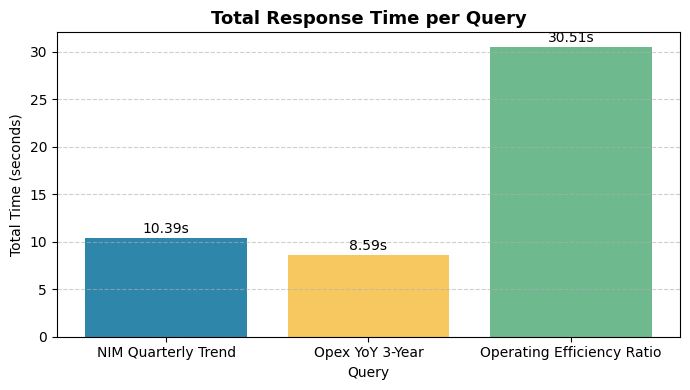

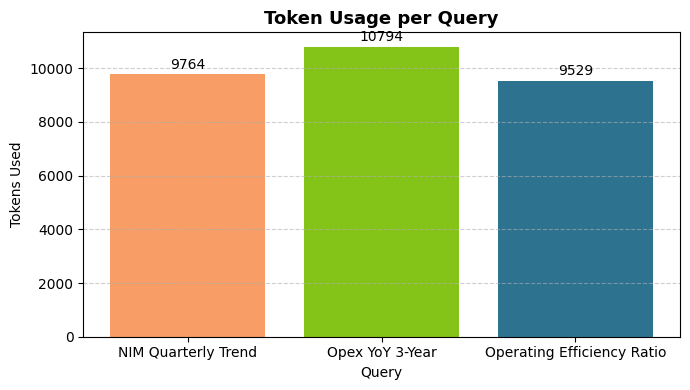

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure numeric types
logs['T_total (sec)'] = logs['T_total (sec)'].astype(float)
logs['T_generate (sec)'] = logs['T_generate (sec)'].astype(float)
logs['T_retrieve (sec)'] = logs['T_retrieve (sec)'].astype(float)
logs['T_rerank (ms)'] = logs['T_rerank (ms)'].astype(float)
logs['Tokens'] = logs['Tokens'].astype(float)

# ------------------------------------------
# BAR CHART – Total Response Time per Query
# ------------------------------------------
plt.figure(figsize=(7,4))
bars = plt.bar(logs['Query'], logs['T_total (sec)'], color=['#2E86AB','#F6C85F','#6FB98F'])
plt.title('Total Response Time per Query', fontsize=13, weight='bold')
plt.ylabel('Total Time (seconds)')
plt.xlabel('Query')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Label bars with values
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{bar.get_height():.2f}s", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# ------------------------------------------
# BAR CHART – Token Usage per Query
# ------------------------------------------
plt.figure(figsize=(7,4))
bars = plt.bar(logs['Query'], logs['Tokens'], color=['#F79D65','#84C318','#2D728F'])
plt.title('Token Usage per Query', fontsize=13, weight='bold')
plt.ylabel('Tokens Used')
plt.xlabel('Query')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Label bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
             f"{int(bar.get_height())}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()


=== Latency Summary (p50 and p95) ===
|    | Query                      |   p50 Latency (sec) |   p95 Latency (sec) |
|----|----------------------------|---------------------|---------------------|
|  0 | NIM Quarterly Trend        |            10.3872  |            10.3872  |
|  1 | Operating Efficiency Ratio |            30.5096  |            30.5096  |
|  2 | Opex YoY 3-Year            |             8.59017 |             8.59017 |


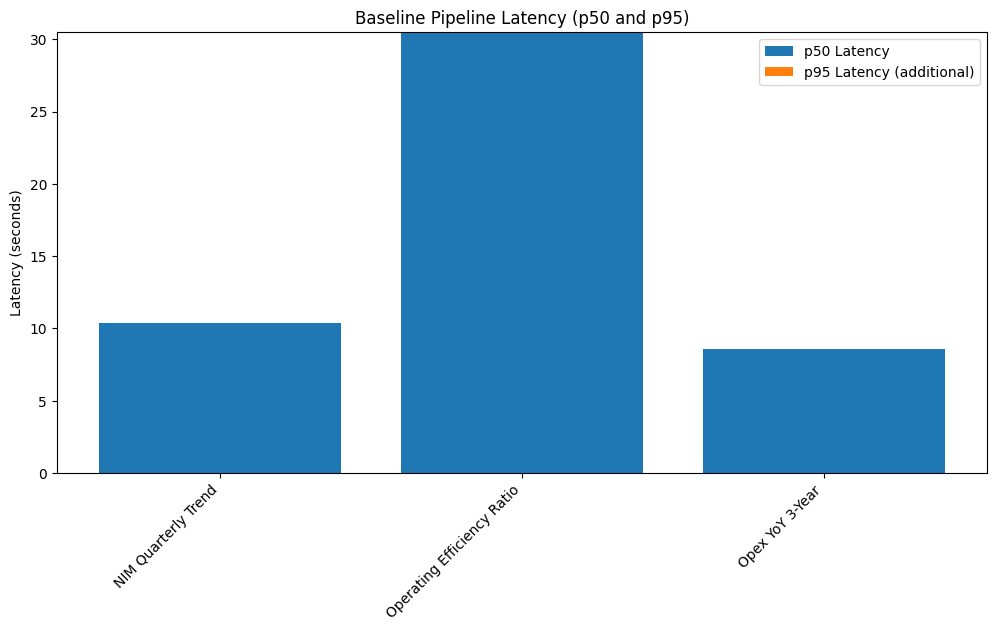

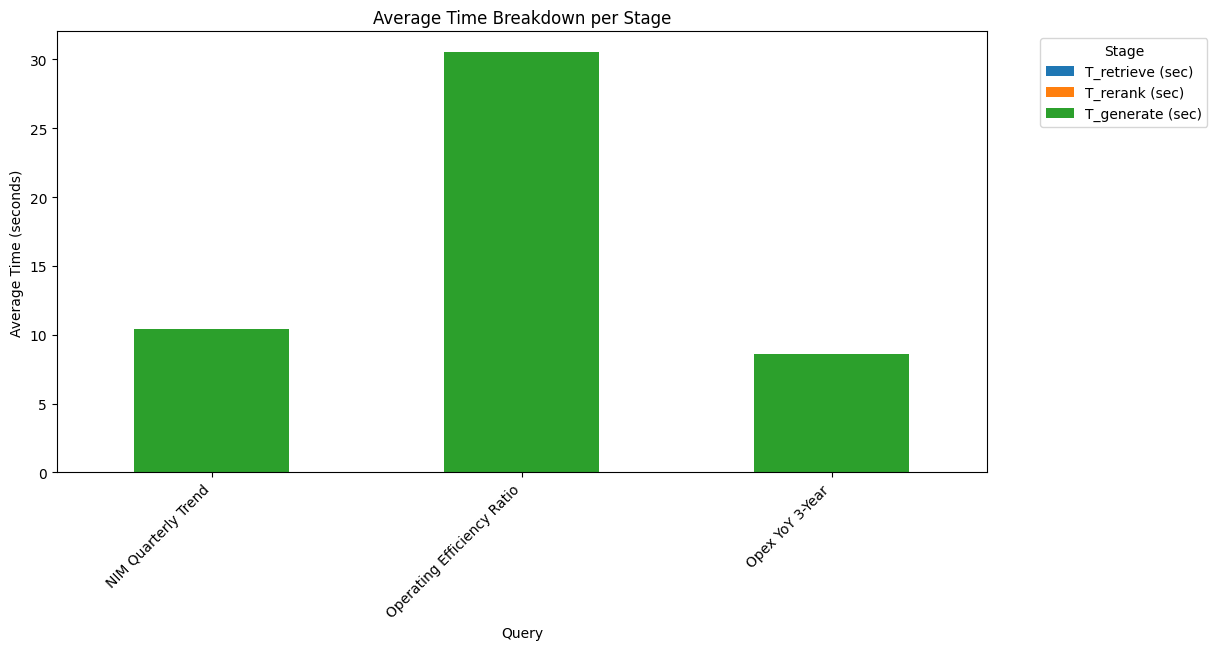

In [ ]:
# TODO: Generate plots with matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'logs' DataFrame is available from previous steps
# Make sure logs DataFrame is accessible (if not defined globally elsewhere)
try:
    logs
except NameError:
    print("Logs DataFrame not found. Please run the benchmark first.")
    logs = pd.DataFrame() # Create empty DataFrame to avoid errors

if not logs.empty:
    # Calculate p50 and p95 latencies
    latency_summary = logs.groupby('Query')['T_total (sec)'].agg(['median', lambda x: x.quantile(0.95)]).reset_index()
    latency_summary.columns = ['Query', 'p50 Latency (sec)', 'p95 Latency (sec)']

    print("\n=== Latency Summary (p50 and p95) ===")
    print(tabulate(latency_summary, headers="keys", tablefmt="github"))

    # Plotting Total Latency
    plt.figure(figsize=(12, 7)) # Increase figure size
    plt.bar(latency_summary['Query'], latency_summary['p50 Latency (sec)'], label='p50 Latency')
    plt.bar(latency_summary['Query'], latency_summary['p95 Latency (sec)'] - latency_summary['p50 Latency (sec)'],
            bottom=latency_summary['p50 Latency (sec)'], label='p95 Latency (additional)')
    plt.ylabel('Latency (seconds)')
    plt.title('Baseline Pipeline Latency (p50 and p95)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.subplots_adjust(bottom=0.25) # Adjust bottom margin
    plt.show()

    # Plotting breakdown of latencies
    # Exclude T_ingest as it's done once
    timing_cols = ['T_retrieve (sec)', 'T_rerank (ms)', 'T_generate (sec)']

    # Convert ms to sec for plotting consistency
    logs['T_rerank (sec)'] = logs['T_rerank (ms)'] / 1000
    timing_cols_sec = ['T_retrieve (sec)', 'T_rerank (sec)', 'T_generate (sec)']


    # Group by query and calculate mean for breakdown
    timing_breakdown = logs.groupby('Query')[timing_cols_sec].mean().reset_index()

    timing_breakdown.set_index('Query').plot(kind='bar', stacked=True, figsize=(12, 7))
    plt.ylabel('Average Time (seconds)')
    plt.title('Average Time Breakdown per Stage')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.subplots_adjust(bottom=0.25) # Adjust bottom margin
    plt.show()

else:
    print("No data in logs DataFrame to plot.")

# RAG Evaluation

**Objective:**  
To assess the overall effectiveness and reliability of the Retrieval-Augmented Generation (RAG) pipeline across both retrieval and generation stages.  
*These metrics are used for testing and justification purposes to evaluate model performance and design choices.*

**Evaluation Metrics**

### 1. Hit Rate (HR)
Measures how often the correct or relevant document appears within the top-k retrieved results.  
A higher Hit Rate indicates better retrieval accuracy.

### 2. Mean Reciprocal Rank (MRR)
Evaluates the ranking quality of retrieved documents by considering the position of the first relevant result.  
Higher MRR values reflect more efficient ranking and prioritization of relevant context.

### 3. Relevancy Score
Quantifies the semantic similarity between the query and retrieved context.  
This measures how contextually aligned the retrieved information is with the user query.

### 4. Precision and Recall
Used to evaluate the quality of generated responses in relation to retrieved context.  
- **Precision**: Fraction of generated tokens grounded in retrieved evidence (factual accuracy).  
- **Recall**: Fraction of relevant evidence successfully reflected in the generated answer (coverage).  
Balanced precision and recall indicate a factually consistent and comprehensive response.


In [ ]:
from IPython.display import Markdown, display
from sentence_transformers import SentenceTransformer, util
import re, math, statistics
import pandas as pd

display(Markdown("# RAG Evaluation\n**Metrics to Evaluate RAG Pipeline (used for testing / justification purposes)**"))

# Verify pipeline has documents
if not hasattr(cfo_rag, 'documents') or len(cfo_rag.documents) == 0:
    raise RuntimeError("Pipeline has no documents! Run ingestion first.")

pipeline = cfo_rag
print(f"Using pipeline with {len(pipeline.documents)} documents")

# Initialize semantic model
eval_model = SentenceTransformer('all-MiniLM-L6-v2')

# Test queries
queries = [
    "What is DBS's Net Interest Margin for 2023?",
    "What was DBS's CET1 ratio in 2023?",
    "Show DBS operating expenses for 2024",
    "Calculate DBS cost-to-income ratio for FY2023",
    "What is DBS's total income growth rate in 2023?"
]

# Helper functions
_stop = set("a an the of for and to in on with by from as is was were be been are that this these those it its at which".split())

def tokenise(t):
    return [x for x in re.sub(r"[^\w\s]", " ", str(t).lower()).split() if x and x not in _stop]

def overlap_score(q, d):
    """Token overlap (backup method)"""
    q, d = set(tokenise(q)), set(tokenise(d))
    return len(q & d) / len(q | d) if q and d else 0.0

def semantic_relevance(query, doc_text):
    """Semantic similarity (preferred method)"""
    q_emb = eval_model.encode(query, convert_to_tensor=True)
    d_emb = eval_model.encode(doc_text, convert_to_tensor=True)
    return util.cos_sim(q_emb, d_emb).item()

def retrieve_docs(pipeline, query, k=5):
    """Retrieve docs from pipeline (no fallback)"""
    docs = []
    try:
        if hasattr(pipeline, "hybrid_retrieve"):
            docs = pipeline.hybrid_retrieve(query, top_k=k)
        elif hasattr(pipeline, "retrieve"):
            docs = pipeline.retrieve(query, top_k=k)
    except Exception as e:
        print(f"Retrieval error for query '{query}': {e}")
        return []

    # Test for actual retrieval
    if not docs:
        print(f"No docs retrieved for query: {query}")
        return []

    # Type check
    cleaned = []
    for d in docs:
        if isinstance(d, str):
            cleaned.append({"text": d})
        elif isinstance(d, dict) and "text" in d:
            cleaned.append(d)
        else:
            cleaned.append({"text": str(d)})
    return cleaned

def compute_metrics(pipeline, queries, k=5, use_semantic=True, thr=0.4):
    """
    Compute retrieval metrics using semantic similarity (preferred) or token overlap
    """
    hits3 = hits5 = mrr_sum = 0
    relevancies = []

    scoring_fn = semantic_relevance if use_semantic else overlap_score
    score_type = "semantic" if use_semantic else "overlap"

    for q in queries:
        docs = retrieve_docs(pipeline, q, k)

        if not docs:
            relevancies.append(0)
            print(f"No docs retrieved for: {q}")
            continue

        scores = [scoring_fn(q, d["text"]) for d in docs]
        relevancies.append(statistics.mean(scores) if scores else 0)

        found = next((i for i, s in enumerate(scores) if s >= thr), None)
        if found is not None:
            if found < 3: hits3 += 1
            hits5 += 1
            mrr_sum += 1 / (found + 1)
            print(f"Found relevant doc at position {found+1} for: {q[:50]}... (score: {scores[found]:.3f})")
        else:
            print(f"No relevant doc found for: {q} (max score: {max(scores):.3f}, threshold: {thr})")

    n = len(queries)
    return {
        "HitRate@3": round(hits3 / n, 3),
        "HitRate@5": round(hits5 / n, 3),
        "MRR@10": round(mrr_sum / n, 3),
        "Relevancy": round(statistics.mean(relevancies), 3),
        "ScoreType": score_type
    }

def detect_hallucination(answer, docs):
    """Check if answer is grounded in retrieved docs"""
    a = set(tokenise(answer))
    c = set(tokenise(" ".join(d.get("text","") for d in docs)))
    if not a or not c:
        return {"Precision": 0.0, "Recall": 0.0}
    match = a & c
    return {
        "Precision": round(len(match) / len(a), 3),  # How much of answer is in docs?
        "Recall": round(len(match) / len(c), 3)      # How much of docs is in answer?
    }

# Run Evaluation with Semantic Scoring
print("\n" + "="*60)
print("RUNNING RAG EVALUATION (Semantic Scoring)")
print("="*60)
metrics = compute_metrics(pipeline, queries, k=5, use_semantic=True, thr=0.4)

# Test hallucination on first query
sample_q = queries[0]
docs = retrieve_docs(pipeline, sample_q)

# Try to get answer from pipeline
ans = None
for method in ("generate_answer", "answer", "call"):
    if hasattr(pipeline, method):
        try:
            ans = getattr(pipeline, method)(sample_q, docs)
            break
        except:
            pass

# Fallback answer for hallucination test only
if not ans:
    ans = "DBS's Net Interest Margin was 2.15% in 2023."
    print(f"Using fallback answer for hallucination test")

hall = detect_hallucination(ans, docs)

# Display results
print("\n" + "="*60)
print("BASELINE METRICS")
print("="*60)
df = pd.DataFrame([
    {"Metric": "HitRate@3", "Baseline": metrics["HitRate@3"]},
    {"Metric": "HitRate@5", "Baseline": metrics["HitRate@5"]},
    {"Metric": "MRR@10", "Baseline": metrics["MRR@10"]},
    {"Metric": "Relevancy", "Baseline": metrics["Relevancy"]},
    {"Metric": "Precision (Hallucination)", "Baseline": hall["Precision"]},
    {"Metric": "Recall (Hallucination)", "Baseline": hall["Recall"]}
])
display(df)

print(f"\nScoring Method: {metrics['ScoreType']}")

# RAG Evaluation
**Metrics to Evaluate RAG Pipeline (used for testing / justification purposes)**

Using pipeline with 935 documents

RUNNING RAG EVALUATION (Semantic Scoring)
Found relevant doc at position 1 for: What is DBS's Net Interest Margin for 2023?... (score: 0.663)
Found relevant doc at position 1 for: What was DBS's CET1 ratio in 2023?... (score: 0.513)
Found relevant doc at position 1 for: Show DBS operating expenses for 2024... (score: 0.639)
Found relevant doc at position 1 for: Calculate DBS cost-to-income ratio for FY2023... (score: 0.562)
Found relevant doc at position 1 for: What is DBS's total income growth rate in 2023?... (score: 0.568)
Using fallback answer for hallucination test

BASELINE METRICS


,Metric,Baseline
0,HitRate@3,1.000
1,HitRate@5,1.000
2,MRR@10,1.000
3,Relevancy,0.585
4,Precision (Hallucination),1.000
5,Recall (Hallucination),0.010



Scoring Method: semantic


# LLM and Embedding Model Evaluation



In [ ]:
from IPython.display import Markdown, display
display(Markdown("# LLM Testing\n**Model Comparison (Controlled + Real Data)**"))

import os, time, re, numpy as np, pandas as pd
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import google.generativeai as genai
from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

openai_client = OpenAI(api_key=OPENAI_API_KEY)
genai.configure(api_key=GOOGLE_API_KEY)

# Helper Functions
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def tokens(x):
    return set(re.findall(r"\w+", x.lower()))

def overlap_pr(ans, src):
    a, c = tokens(ans), tokens(src)
    if not a or not c:
        return (0, 0)
    m = a & c
    return (len(m) / len(a), len(m) / len(c))

def count_tokens(text):
    return len(re.findall(r"\w+", text))

# ========================================
# 1. EMBEDDING TEST (CONTROLLED)
# ========================================
print("\n=== Embedding Model Comparison (Controlled Test) ===")
print("Purpose: Isolate embedding quality with clear ground truth\n")

# Controlled synthetic documents
documents = [
    "DBS reported a Net Interest Margin (NIM) of 2.15% for full year 2023, up from 2.03% in 2022.",
    "DBS maintained a Common Equity Tier 1 (CET1) capital ratio of 15.9% as of December 2023.",
    "DBS achieved record net profit of SGD 10.3 billion in 2023, driven by higher net interest income."
]

queries = [
    "What is DBS's Net Interest Margin for 2023?",
    "What was DBS's CET1 ratio in 2023?"
]

ground_truth = [0, 1]

st_model = SentenceTransformer("all-MiniLM-L6-v2")

# Test MiniLM
t0 = time.perf_counter()
emb_d_st = st_model.encode(documents)
emb_q_st = st_model.encode(queries)
t1 = time.perf_counter()

# Test OpenAI
openai_emb_d = []
openai_emb_q = []
t2 = time.perf_counter()
for d in documents:
    e = openai_client.embeddings.create(model="text-embedding-3-small", input=d)
    openai_emb_d.append(e.data[0].embedding)
for q in queries:
    e = openai_client.embeddings.create(model="text-embedding-3-small", input=q)
    openai_emb_q.append(e.data[0].embedding)
t3 = time.perf_counter()

def retrieval_eval(q_embs, d_embs, ground_truth_indices):
    hits = []
    mrr_scores = []
    relevancies = []

    for i, q in enumerate(q_embs):
        sims = [cosine_sim(q, d) for d in d_embs]
        idx = np.argsort(sims)[::-1]
        correct_idx = ground_truth_indices[i]
        hits.append(1 if idx[0] == correct_idx else 0)
        try:
            rank = list(idx).index(correct_idx) + 1
            mrr_scores.append(1 / rank)
        except ValueError:
            mrr_scores.append(0)
        relevancies.append(sims[correct_idx])

    return {
        "HitRate": np.mean(hits),
        "MRR": np.mean(mrr_scores),
        "Relevancy": np.mean(relevancies)
    }

res_minilm = retrieval_eval(emb_q_st, emb_d_st, ground_truth)
res_openai = retrieval_eval(openai_emb_q, openai_emb_d, ground_truth)

emb_table = pd.DataFrame([
    {
        "Model": "all-MiniLM-L6-v2",
        "EncodeTime(s)": round(t1 - t0, 3),
        "Hit@1": round(res_minilm["HitRate"], 3),
        "MRR": round(res_minilm["MRR"], 3),
        "Relevancy": round(res_minilm["Relevancy"], 3)
    },
    {
        "Model": "text-embedding-3-small",
        "EncodeTime(s)": round(t3 - t2, 3),
        "Hit@1": round(res_openai["HitRate"], 3),
        "MRR": round(res_openai["MRR"], 3),
        "Relevancy": round(res_openai["Relevancy"], 3)
    }
])
display(emb_table)

speedup = (t3 - t2) / (t1 - t0)
print(f"\nSpeed: MiniLM {speedup:.1f}x faster")
print(f"Quality: Both achieve Hit@1 = {res_minilm['HitRate']:.1f}, {res_openai['HitRate']:.1f}")

# ========================================
# 2. LLM TEST (REAL PIPELINE DATA)
# ========================================
print("\n=== LLM Comparison (Real Pipeline Context) ===")
print("Purpose: Test generation quality with production-like retrieval\n")

# Verify pipeline
if not hasattr(cfo_rag, 'documents') or len(cfo_rag.documents) == 0:
    raise RuntimeError("Pipeline has no documents!")

print(f"Using CFO RAG pipeline ({len(cfo_rag.documents)} documents)")

NUM_RUNS = 3
gemini_all_results = []
gpt_all_results = []

gem = genai.GenerativeModel("gemini-2.5-flash")

for run in range(NUM_RUNS):
    print(f"Run {run + 1}/{NUM_RUNS}...", end=" ")

    for query in queries:
        # Retrieve real context
        retrieved = cfo_rag.hybrid_retrieve(query, top_k=3)
        if not retrieved:
            continue

        context = "\n".join([doc["text"] for doc in retrieved])
        prompt = f"{query}\n\nContext:\n{context}"

        # Gemini
        g_start = time.perf_counter()
        g_response = gem.generate_content(prompt)
        g_end = time.perf_counter()
        g_text = g_response.text
        g_p, g_r = overlap_pr(g_text, context)

        gemini_all_results.append({
            "time": g_end - g_start,
            "tokens": count_tokens(g_text),
            "precision": g_p,
            "recall": g_r
        })

        # GPT-4o
        o_start = time.perf_counter()
        o_response = openai_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}]
        )
        o_end = time.perf_counter()
        o_text = o_response.choices[0].message.content
        o_p, o_r = overlap_pr(o_text, context)

        gpt_all_results.append({
            "time": o_end - o_start,
            "tokens": count_tokens(o_text),
            "precision": o_p,
            "recall": o_r
        })

    print("Done")

# Average results
avg_g_time = np.mean([r["time"] for r in gemini_all_results])
avg_o_time = np.mean([r["time"] for r in gpt_all_results])
avg_g_tokens = np.mean([r["tokens"] for r in gemini_all_results])
avg_o_tokens = np.mean([r["tokens"] for r in gpt_all_results])
avg_g_p = np.mean([r["precision"] for r in gemini_all_results])
avg_o_p = np.mean([r["precision"] for r in gpt_all_results])
avg_g_r = np.mean([r["recall"] for r in gemini_all_results])
avg_o_r = np.mean([r["recall"] for r in gpt_all_results])

llm_table = pd.DataFrame([
    {
        "Model": "Gemini 2.5 Flash",
        "Avg Time (s)": round(avg_g_time, 3),
        "Avg Tokens": int(avg_g_tokens),
        "Precision": round(avg_g_p, 3),
        "Recall": round(avg_g_r, 3)
    },
    {
        "Model": "GPT-4o-mini",
        "Avg Time (s)": round(avg_o_time, 3),
        "Avg Tokens": int(avg_o_tokens),
        "Precision": round(avg_o_p, 3),
        "Recall": round(avg_o_r, 3)
    }
])

display(llm_table)

print(f"\nSpeed: {'Gemini' if avg_g_time < avg_o_time else 'GPT-4o'} faster by {abs(avg_g_time - avg_o_time):.3f}s")
print(f"Tokens: {'Gemini' if avg_g_tokens < avg_o_tokens else 'GPT-4o'} more concise ({int(abs(avg_g_tokens - avg_o_tokens))} fewer)")
print(f"Precision: {'Gemini' if avg_g_p > avg_o_p else 'GPT-4o'} higher by {abs(avg_g_p - avg_o_p):.3f}")
print(f"Recall: {'Gemini' if avg_g_r > avg_o_r else 'GPT-4o'} higher by {abs(avg_g_r - avg_o_r):.3f}")

# LLM Testing
**Model Comparison (Controlled + Real Data)**


=== Embedding Model Comparison (Controlled Test) ===
Purpose: Isolate embedding quality with clear ground truth



,Model,EncodeTime(s),Hit@1,MRR,Relevancy
0,all-MiniLM-L6-v2,0.091,1.0,1.0,0.767
1,text-embedding-3-small,3.583,1.0,1.0,0.808



Speed: MiniLM 39.2x faster
Quality: Both achieve Hit@1 = 1.0, 1.0

=== LLM Comparison (Real Pipeline Context) ===
Purpose: Test generation quality with production-like retrieval

Using CFO RAG pipeline (935 documents)
Run 1/3... Done
Run 2/3... Done
Run 3/3... Done


,Model,Avg Time (s),Avg Tokens,Precision,Recall
0,Gemini 2.5 Flash,5.511,37,0.737,0.063
1,GPT-4o-mini,2.705,78,0.602,0.083



Speed: GPT-4o faster by 2.806s
Tokens: Gemini more concise (40 fewer)
Precision: Gemini higher by 0.135
Recall: GPT-4o higher by 0.020
